In [27]:
import sys
sys.path.append('../')
import os

In [28]:
BASE_DIR = '../data/historical_klines/'

### ライブラリのインストール

In [29]:
import pandas as pd
import pandas.errors
import numpy as np
from datetime import datetime
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import joblib

import pandas as pd
import json


#gmo api に必要なライブラリ
import requests
#import json
import hmac
import hashlib
import time
from datetime import datetime
from dateutil.relativedelta import relativedelta

#自作モジュール
from kumo_library.gmo_api.gmo_api import GmoApi_private

In [30]:
with open('../secrets.json') as f:
    secrets = json.load(f)

apiKey    = secrets["gmo_api_key"]
secretKey = secrets["gmo_api_secret"]

gmo_api_private = GmoApi_private(apiKey, secretKey)

BASE_DIR = '../data/historical_klines/'

### パラメータの指定

In [31]:
#パラメータの指定

symbols = [
    'ADA',
    'ASTR',
    'ATOM',
    'BAT',
    'BCH',
    'BTC',
    'DAI',
    'DOT',
    'ENJ',
    'ETH',
    'FCR',
    'LINK',
    'LTC',
    'MKR',
    'MONA',
    'OMG',
    'QTUM',
    'XEM',
    'XLM',
    'XRP',
    'XTZ',
    'XYM',
]
    
interval = '5min'

long_theta = 0.4
short_theta = 0.3

### データの保存

In [32]:
str_date = pd.to_datetime(datetime.now().date().strftime('%Y%m%d')) - relativedelta(days = 1)
end_date = pd.to_datetime(datetime.now().date().strftime('%Y%m%d'))
now_date = str_date
while (now_date <= end_date):
    print(now_date)
    for symbol in symbols:
        klines = gmo_api_private.GmoApi_public.get_klines(symbol=symbol, interval=interval, date=now_date.strftime('%Y%m%d'))['data']
        save_dir = f'{BASE_DIR}{interval}/{symbol}/'
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        pd.DataFrame(klines).to_csv(f"{save_dir}{symbol}_{interval}_{now_date.strftime('%Y%m%d')}.csv", index=False)
    now_date = now_date + relativedelta(days = 1)

2023-07-12 00:00:00
2023-07-13 00:00:00


### データの読み込み

In [33]:
use_str_date = pd.to_datetime(datetime.now().date().strftime('%Y%m%d')) - relativedelta(days = 2)
use_end_date = pd.to_datetime(datetime.now().date().strftime('%Y%m%d'))

In [34]:
df = pd.DataFrame()

for symbol in symbols:
    for date in pd.date_range(start=use_str_date, end=use_end_date):
        try:
            temp_df = pd.read_csv(f'{BASE_DIR}{interval}/{symbol}/{symbol}_{interval}_{date.strftime("%Y%m%d")}.csv')
            temp_df['symbol'] = symbol  # Add a new column to store symbol name
            df = pd.concat([df, temp_df], axis=0)
        except (FileNotFoundError, pd.errors.EmptyDataError):
            print(f'File {BASE_DIR}{interval}/{symbol}/{symbol}_{interval}_{date.strftime("%Y%m%d")}.csv not found or empty. Skipping...')

# Assuming df is your dataframe and 'openTime' is your column with the date
df['openTime'] = pd.to_datetime(df['openTime'], unit='ms')  # convert from UNIX timestamp, if necessary
df["datetime_f"] = df['openTime'] 
df["symbol_f"] = df['symbol']

# Convert 'symbol' and 'openTime' columns to index, creating a MultiIndex
df.set_index(['openTime', 'symbol'], inplace=True)


### 特徴量の計算

In [35]:
def cal_technical_f(df):
    df = df.copy()
    #移動平均からの乖離率
    for i in [5, 20]:
        df[f"{i}sma_d_rate"] = df.groupby("symbol")["close"].transform(lambda x: x/(x.rolling(i).mean()) - 1)
    #直近のリターン
    df["past_1return"] = df.groupby("symbol")["close"].transform(lambda x: x/x.shift(1) - 1)
    #高値と安値の差額を終値で除した値
    df["h_l_by_c"] = (df["high"] - df["low"])/df["close"]
    #始値と終値の差を終値で除した値
    df["c_o_by_c"] = (df["close"] - df["open"])/df["close"]
    return df

def cal_category_f(df):
    df = df.copy()
    #日付情報を分割
    df["month"] = df["datetime_f"].dt.month
    df["day"] = df["datetime_f"].dt.day
    df["hour"] = df["datetime_f"].dt.hour
    df["week"] = df["datetime_f"].dt.dayofweek #曜日
    return df

def cal_target(df):
    df.loc[:, "return"] = df.groupby("symbol")["close"].transform(lambda x: x.shift(-1)/x - 1)
    df.loc[:, "return_rank"] = df.groupby("openTime")["return"].transform(lambda x: x.rank(method = "min"))
    return df

df = cal_technical_f(df)
df = cal_category_f(df)
df = cal_target(df)

In [36]:
f_list = [
    #"open",
    #"close",
    #"high",
    #"low",
    "volume", #注文現物通貨量
    #"q_volume", #注文引用通貨量
    #"n_trades",
    #"taker_vol", #成行注文現物通貨量
    #"taker_q_vol", #成行注文引用通貨量
    #テクニカル特徴量
    "5sma_d_rate",
    "20sma_d_rate",
    #"75sma_d_rate",
    #"200sma_d_rate",
    "past_1return",
    "h_l_by_c",
    "c_o_by_c",
    #"taker_r",
    #"taker_q_r", 
    #"vol_by_trade",
    #カテゴリ変数
    "symbol_f",
    #"month",
    #"day",
    "hour",
    #"week",
]

target = "return_rank"

In [37]:
#ラベルエンコーディング
le = LabelEncoder()
df['symbol_f'] = le.fit_transform(df['symbol_f'])

### モデルの読み込み

In [38]:
ranker = joblib.load('./ranker_model.pkl')

### 予測

In [39]:
df.loc[:,"predict_value"] = ranker.predict(df[f_list]).copy()
df["predict_rank"] = df.groupby("openTime")["predict_value"].transform(lambda x: x.rank(method = "min"))

In [40]:
df.sort_index(level = 'openTime')

open         high          low   
openTime            symbol                                          
2023-07-10 21:00:00 ATOM       1332.000     1333.000     1332.000  \
                    BTC     4359999.000  4360903.000  4348584.000   
                    ETH      267919.000   267919.000   267790.000   
                    LTC       13754.000    13754.000    13754.000   
2023-07-10 21:05:00 ADA          41.062       41.062       41.062   
...                                 ...          ...          ...   
2023-07-13 01:50:00 XEM           4.272        4.273        4.272   
                    XRP          65.500       65.550       65.499   
                    XTZ         114.432      114.432      114.432   
2023-07-13 01:55:00 ATOM       1259.000     1259.000     1259.000   
                    ETH      260580.000   260598.000   260580.000   

                                  close      volume          datetime_f   
openTime            symbol                                                
2023-07-10 21:00:00 ATOM       1333.000     51.0300 2023-07-10 21:00:00  \
                    BTC     4350800.000      0.5354 2023-07-10 21:00:00   
                    ETH      267790.000      0.2900 2023-07-10 21:00:00   
                    LTC       13754.000      2.4500 2023-07-10 21:00:00   
2023-07-10 21:05:00 ADA          41.062      2.0000 2023-07-10 21:05:00   
...                                 ...         ...                 ...   
2023-07-13 01:50:00 XEM           4.273    560.0000 2023-07-13 01:50:00   
                    XRP          65.546  78491.0000 2023-07-13 01:50:00   
                    XTZ         114.432     35.0000 2023-07-13 01:50:00   
2023-07-13 01:55:00 ATOM       1259.000      2.0000 2023-07-13 01:55:00   
                    ETH      260598.000      1.2000 2023-07-13 01:55:00   

                            symbol_f  5sma_d_rate  20sma_d_rate  past_1return   
openTime            symbol                                                      
2023-07-10 21:00:00 ATOM           2          NaN           NaN           NaN  \
                    BTC            5          NaN           NaN           NaN   
                    ETH            9          NaN           NaN           NaN   
                    LTC           12          NaN           NaN           NaN   
2023-07-10 21:05:00 ADA            0          NaN           NaN           NaN   
...                              ...          ...           ...           ...   
2023-07-13 01:50:00 XEM           17     0.007023      0.021027      0.000000   
                    XRP           19     0.000880      0.000543      0.000702   
                    XTZ           20    -0.002114     -0.008755      0.000052   
2023-07-13 01:55:00 ATOM           2     0.000000      0.000477      0.000000   
                    ETH            9     0.000451      0.001168      0.000069   

                            h_l_by_c  c_o_by_c  month  day  hour  week   
openTime            symbol                                               
2023-07-10 21:00:00 ATOM    0.000750  0.000750      7   10    21     0  \
                    BTC     0.002831 -0.002114      7   10    21     0   
                    ETH     0.000482 -0.000482      7   10    21     0   
                    LTC     0.000000  0.000000      7   10    21     0   
2023-07-10 21:05:00 ADA     0.000000  0.000000      7   10    21     0   
...                              ...       ...    ...  ...   ...   ...   
2023-07-13 01:50:00 XEM     0.000234  0.000234      7   13     1     3   
                    XRP     0.000778  0.000702      7   13     1     3   
                    XTZ     0.000000  0.000000      7   13     1     3   
2023-07-13 01:55:00 ATOM    0.000000  0.000000      7   13     1     3   
                    ETH     0.000069  0.000069      7   13     1     3   

                              return  return_rank  predict_value  predict_rank  
openTime            symbol                                     

### 可視化

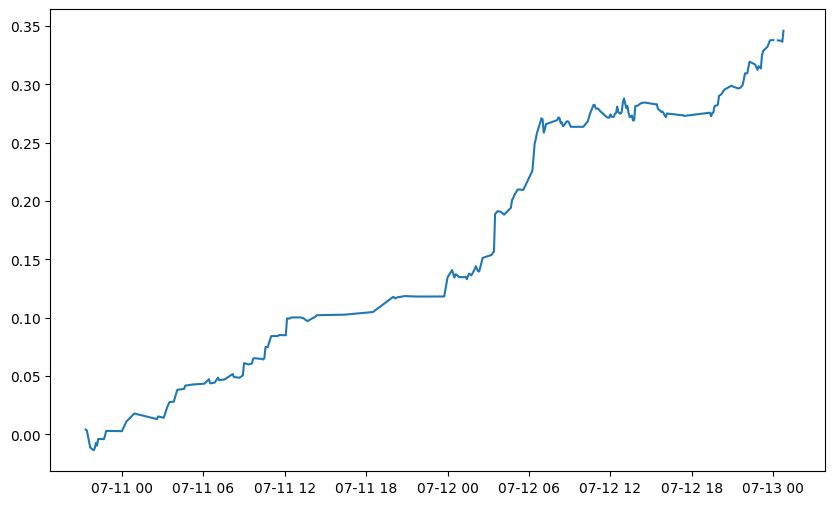

In [41]:
plt.figure(figsize=(10,6))
plt.plot(df.loc[df["predict_rank"] > int(len(symbols)*long_theta)].groupby(level = "openTime")["return"].mean().cumsum())

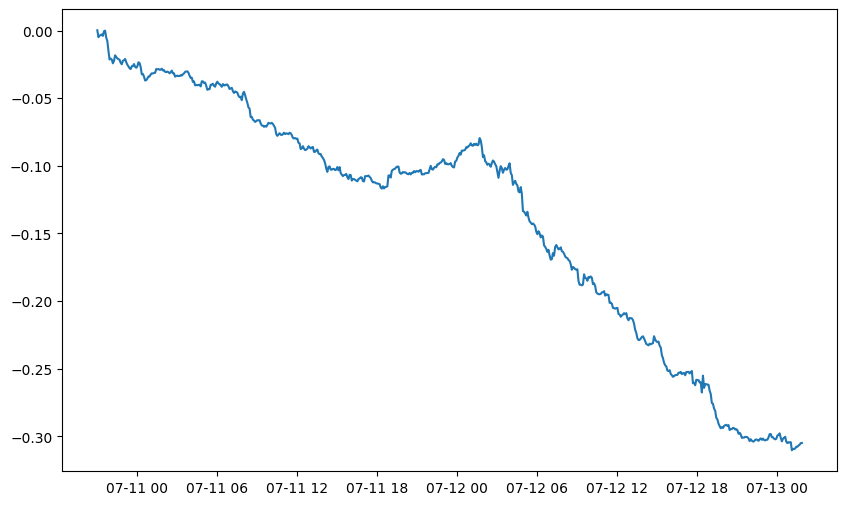

In [42]:
plt.figure(figsize=(10,6))
plt.plot(df.loc[df["predict_rank"] <= int(len(symbols)*short_theta)].groupby(level = "openTime")["return"].mean().cumsum())

### ロングリスト・ショートリストの作成

In [43]:
now_df = list(df.groupby(level='openTime'))[-1][1]
long_list = now_df.loc[df["predict_rank"] > int(len(symbols)*long_theta)].index.get_level_values('symbol').to_list()
short_list = now_df.loc[df["predict_rank"] <= int(len(symbols)*short_theta)].index.get_level_values('symbol').to_list()

In [44]:
print(long_list)
print(short_list)

[]
['ATOM', 'ETH']


### ポジション取得

#### 資産残高を取得

In [45]:
gmo_api_private.get_balance()

{'status': 0,
 'data': [{'amount': '59165',
   'available': '59165',
   'conversionRate': '1',
   'symbol': 'JPY'},
  {'amount': '0.0071',
   'available': '0.0071',
   'conversionRate': '4106925',
   'symbol': 'BTC'},
  {'amount': '0.07',
   'available': '0.07',
   'conversionRate': '253184',
   'symbol': 'ETH'},
  {'amount': '0',
   'available': '0',
   'conversionRate': '38213',
   'symbol': 'BCH'},
  {'amount': '0',
   'available': '0',
   'conversionRate': '12989',
   'symbol': 'LTC'},
  {'amount': '150',
   'available': '150',
   'conversionRate': '63.68',
   'symbol': 'XRP'},
  {'amount': '0',
   'available': '0',
   'conversionRate': '4.055',
   'symbol': 'XEM'},
  {'amount': '0',
   'available': '0',
   'conversionRate': '12.746',
   'symbol': 'XLM'},
  {'amount': '0',
   'available': '0',
   'conversionRate': '25.865',
   'symbol': 'BAT'},
  {'amount': '0',
   'available': '0',
   'conversionRate': '80.312',
   'symbol': 'OMG'},
  {'amount': '0',
   'available': '0',
   'conve

### 未約定注文のキャンセル

In [46]:
#for symbol in symbols:
    

#### 発注アルゴリズム

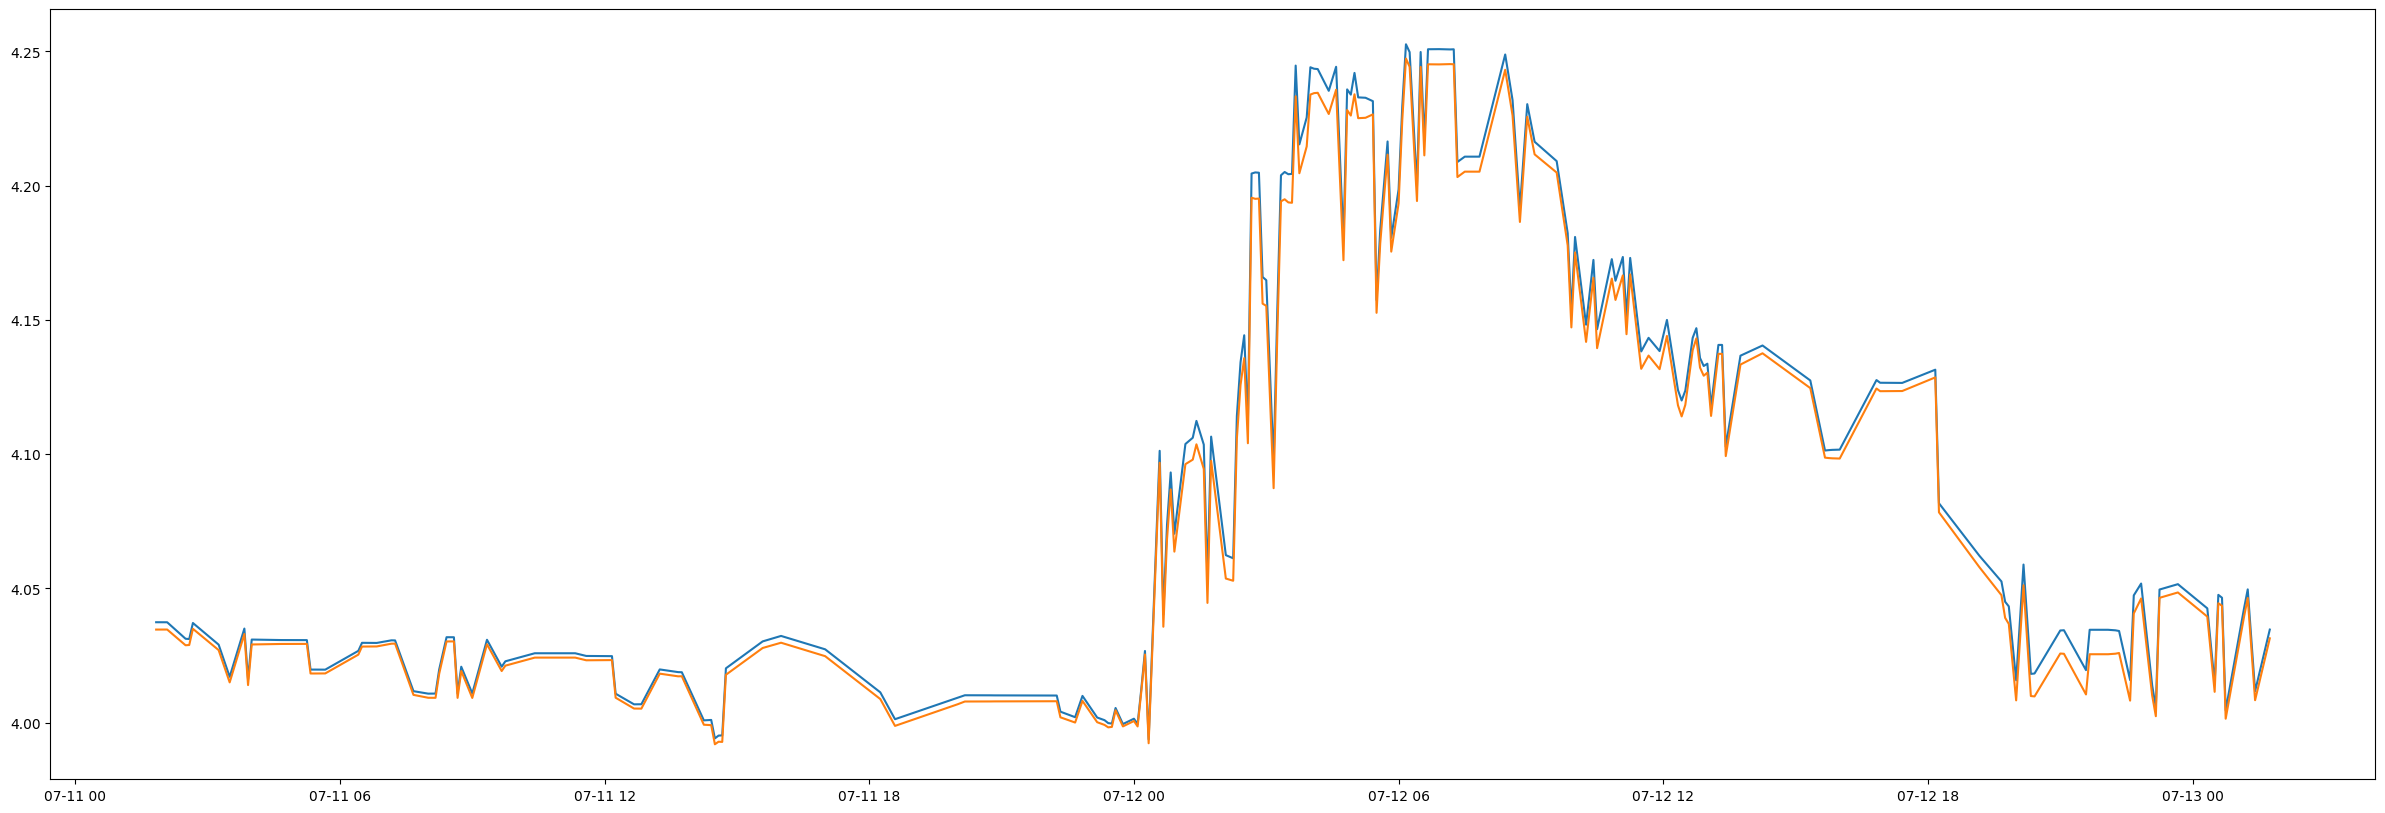

In [47]:
plot_df = df[df.index.get_level_values('symbol') == 'XYM']

plt.figure(figsize=(30,10))
#plt.plot(plot_df.index.get_level_values('openTime'), plot_df['close'])
plt.plot(plot_df.index.get_level_values('openTime'), plot_df['close'].transform(lambda x: x + x.rolling(20).std()*0.1)  )
plt.plot(plot_df.index.get_level_values('openTime'), plot_df['close'].transform(lambda x: x - x.rolling(20).std()*0.1)  )

In [48]:
display(pd.DataFrame({'close': plot_df['close'], 'entry_buy_price':  plot_df['close'] - plot_df['close'].rolling(12).std()*0.001}))

,,close,entry_buy_price
openTime,symbol,,
2023-07-10 21:10:00,XYM,4.046,NaN
2023-07-10 21:20:00,XYM,4.064,NaN
2023-07-10 21:25:00,XYM,4.057,NaN
2023-07-10 21:30:00,XYM,4.045,NaN
2023-07-10 21:40:00,XYM,4.051,NaN
...,...,...,...
2023-07-13 00:45:00,XYM,4.003,4.002980
2023-07-13 01:10:00,XYM,4.041,4.040981
2023-07-13 01:15:00,XYM,4.048,4.047981


In [49]:
rule_df = pd.DataFrame(gmo_api_private.GmoApi_public.get_rules()['data']) 
display(rule_df)

,symbol,minOrderSize,maxOrderSize,sizeStep,tickSize,takerFee,makerFee
0,BTC,0.0001,5,0.0001,1,0.0005,-0.0001
1,ETH,0.01,100,0.0001,1,0.0005,-0.0001
2,BCH,0.01,100,0.001,1,0.0009,-0.0003
3,LTC,0.1,500,0.01,1,0.0009,-0.0003
4,XRP,1,100000,1,0.001,0.0005,-0.0001
5,XEM,1,50000,1,0.001,0.0009,-0.0003
6,XLM,1,50000,1,0.001,0.0009,-0.0003
7,BAT,1,20000,1,0.001,0.0009,-0.0003
8,OMG,0.1,3000,0.1,0.001,0.0009,-0.0003
9,XTZ,0.1,5000,0.1,0.001,0.0009,-0.0003


In [50]:
def round_to_tick_size(number, tick_size):
    if tick_size == 1:
        return round(number)
    else:
        return round(number / tick_size) * tick_size

In [51]:
symbol = 'BTC'
side = 'SELL'

last_price = df[df.index.get_level_values('symbol') == symbol]['close'].tail(1).values[0]
tick_size = float(rule_df[rule_df['symbol'] == symbol]['tickSize'].values[0])


if side == 'SELL':
    limit_price = round_to_tick_size(last_price + tick_size, tick_size)
elif side == 'BUY':
    limit_price = round_to_tick_size(last_price - tick_size, tick_size)
    
print(limit_price)

4232811


In [52]:
#gmo_api_private.post_order_by_JPY(symbol, side, 'LIMIT', 500, price=limit_price)

{'status': 0, 'data': '3663295968', 'responsetime': '2023-07-13T01:55:33.299Z'}